In [56]:
import numpy as np
import scipy.integrate as spi
from scipy.special import expit
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from itertools import product

import random
import copy
import sys

%matplotlib inline

### Class Definitions

In [57]:
class Grid:

    """ 
    Grid Class implementation for finite and infinite grids, with the possibility of transformations.

    If a transformation is defined, the grid is constructed in the transformed space with the given resolution.
    Then, the grid lines are transformed back to the original space.
    """
    
    def __init__(self, bounds, resolution, transformation=None, inverse_transformation=None):
        """
        Initializes the grid based on space intervals and resolution.

        Args:
            bounds (list of tuples): [(x_min, x_max), (y_min, y_max), ...] with np.inf for unboundedness.
            resolution (list of ints): Number of cells (divisions) in each dimension.
            transformation (function or list of functions): Transformation functions for the grid coordinates.
                                                            These functions should be able to handle np.inf.
        """
        self.bounds = copy.deepcopy(bounds)
        self.dimension = len(bounds)
        self.resolution = resolution
        self.indices = list((product(*[range(res) for res in self.resolution])))

        self.transformation = transformation
        self.inverse_transformation = inverse_transformation
        self.transformed = False
        self.tf_bounds = copy.deepcopy(bounds) #will be changed in case of transformation

        #Transformation
        if self.transformation is not None:
            
            if isinstance(self.transformation, list):
                if len(self.transformation) != self.dimension:
                    raise ValueError("The number of transformation functions must match the grid dimension.")
            elif callable(self.transformation):
                self.transformation = [self.transformation] * self.dimension
                if callable(self.inverse_transformation):
                    self.inverse_transformation = [self.inverse_transformation] * self.dimension
            else:
                raise ValueError("Transformation must be a function or a list of functions.")
            
            
            for i, bound in enumerate(self.bounds):
                self.tf_bounds[i] = (self.transformation[i](bound[0]), self.transformation[i](bound[1]))

            self.tf_grid_lines = [np.linspace(start, end, num+1) for (start, end), num in zip(self.tf_bounds, self.resolution)]
            self.grid_lines = [np.vectorize(self.inverse_transformation[dim])(self.tf_grid_lines[dim]) for dim in range(self.dimension)]

            self.transformed = True

        else:
            self.grid_lines = [np.linspace(start, end, num+1) for (start, end), num in zip(self.bounds, self.resolution)]
            self.tf_grid_lines = copy.deepcopy(self.grid_lines)

    
    def transform(self, coord):
        """
        Transforms a given coordinate using the transformation functions.

        Args: coord (tuple): Real-world coordinate (e.g., (x, y)).
        """
        if not self.transformed:
            raise ValueError("No transformation functions defined.")
        else:
            return tuple(self.transformation[dim](coord[dim]) for dim in range(self.dimension))
        

    def inverse_transform(self, coord):
        """
        Transforms a given coordinate from the transformed space using the inverse transformation functions.

        Args: coord (tuple): Transformed space coordinate (e.g., (x, y)).
        """
        if not self.transformed:
            raise ValueError("No transformation functions defined.")
        else:
            return tuple(self.inverse_transformation[dim](coord[dim]) for dim in range(self.dimension))
        

       
    def get_cell_index(self, coord, transformed_space = False):
        """
        Finds the grid cell index for a given coordinate.
            For the boundary: point is always contained in the 'larger' index

        Args: coord (tuple): Real-world coordinate (e.g., (x, y)).

        Returns: idx (tuple): The grid cell index (e.g., (i, j)).
        """

        if len(coord) != self.dimension:
            raise ValueError("Coordinate dimensionality does not match space intervals.")
        
        if not transformed_space:
            coord = self.transform(coord)
        
        bounds = self.tf_bounds #search always in transformed space to avoid errors with np.inf
                    
        for dim in range(self.dimension):
            if (coord[dim] < bounds[dim][0]) or (coord[dim] > bounds[dim][1]):
                raise ValueError("Coordinate is out of bounds.")
                    
        idx = tuple(int((coord[dim] - bounds[dim][0]) /(bounds[dim][1] - bounds[dim][0]) * self.resolution[dim])
                        for dim in range(self.dimension))

        return idx


    
    def get_cell_coordinates(self, idx, transformed_space = False):
        """
        Returns the coordinates of a grid cell.

        Args: idx (tuple): The grid cell index (e.g., (i, j)).

        Returns: coords (list of tuples): The coordinates of the grid cell.
        """

        if not transformed_space:
            return [self.grid_lines[dim][i:i+2] for dim, i in enumerate(idx)]
        else:
            return [self.tf_grid_lines[dim][i:i+2] for dim, i in enumerate(idx)]

    
    def choose_random_point_from_cell(self, idx):
        """
        Chooses a random point from a grid cell corresponding to the transformed space (because of unboundedness).
        
        Args: idx (tuple): The grid cell index (e.g., (i, j)).

        Returns: point (tuple): The random point in original coordinates.
        """

        if self.transformed:
            tf_coords = tuple(random.uniform(self.tf_grid_lines[dim][i], self.tf_grid_lines[dim][i+1]) for dim, i in enumerate(idx))
            rnd_point = self.inverse_transform(tf_coords)
        else:
            rnd_point = tuple(random.uniform(self.grid_lines[dim][i], self.grid_lines[dim][i+1]) for dim, i in enumerate(idx))
        
        return rnd_point
    

    def plot_2_dimensions_of_grid_with_vectorfield(self, dim1 = 0, dim2 = 1, vectorfield=None, streamplot=False):
        """
        Plots the grid in 2 dimensions.

        Args:
            dim1 (int): Dimension to plot on the x-axis.
            dim2 (int): Dimension to plot on the y-axis.
            vectorfield (function): Vectorfield to plot on the grid.
        
        Problem: How to plot the vectorfield in the transformed space?
        """
        """
        X = self.grid_lines[dim1]
        Y = self.grid_lines[dim2]
        X, Y = np.meshgrid(X, Y)

        if vectorfield is None:
            U, V = np.zeros_like(X), np.zeros_like(Y)
        else:
            U, V = vectorfield(X, Y)

        plt.figure(figsize=(8, 8))
        plt.quiver(X, Y, U, V, color='b', alpha=0.3)
        plt.grid(True)

        if streamplot:
            plt.streamplot(X, Y, U, V, color='b', linewidth=0.7)

        plt.show()
       
        """

        raise NotImplementedError("This method is not implemented yet.")




In [58]:
class Simulator:
    """
    Class for simulating trajectories on a grid.
    Expects a grid object from the Grid class.
    """

    def __init__(self, grid):
        self.grid = grid
        self.initial_conditions = []
        self.initial_condition_ids = [] # To keep track of the initial condition indices
        
        #Possibly store differential equation and control vectors in the class as well.
        self.diff_eq = None
        self.control_vectors = None
        
        self.result_df = None

    def choose_initial_conditions(self, num_conditions_per_cell=10):
        """
        Randomly chooses initial conditions for the simulation based on the grid cells.
    	"""
        
        self.initial_conditions = []    # Clear the list of initial conditions
        self.initial_condition_ids = [] 
                
        for idx in self.grid.indices:
            for i in range(num_conditions_per_cell):
                point = self.grid.choose_random_point_from_cell(idx)
                self.initial_conditions.append(point)
                id = "-".join(map(str, idx)) + f"_{i}"
                self.initial_condition_ids.append(id)

                

    def simulate_single(self, f, init_cond, control_vectors, timesteps=10, dt=1, trajectory_id='0', save_result=False):   
        """
        Simulates the differential equation for a given initial condition and time period.
        
        Args:
            f (function): The system of differential equations, that takes a control vector as an input.
            init_cond (list): The initial condition for the simulation.
            control_vectors (list): The control vectors for the simulation in the form [(t1, u1), (t2, u2), ...].
                                    Here, the control u1 is applied at time t1, first has to be 0.
                                    Also, up to now, the control times should be at the timesteps, otherwise this step won't be saved.
            timesteps (int): The number of time steps to simulate.
            dt (float): The time step size.
            trajectory_id (int): The ID of the trajectory.
            save_result (bool): If True, the results are stored in the result_df attribute.

        Returns: df (DataFrame): A DataFrame containing the simulation results.
        """


        result = []
        
        tf = (timesteps+1) * dt  # Final time
        t_array = np.arange(0, tf, dt)

        last_control_time = 0

        for k, (time,control) in enumerate(control_vectors):
            if time > tf:
                raise ValueError("Control time exceeds final time.")
            
            if k < len(control_vectors) - 1:
                next_control_time = control_vectors[k+1][0]
            else:
                next_control_time = tf

            sim_t_array = t_array[t_array <= next_control_time]
            t_array = t_array[t_array >= next_control_time]
            
            sol = spi.solve_ivp(f, [last_control_time, next_control_time], init_cond, t_eval=sim_t_array, args=(control,))
            
            init_cond = sol.y[:, -1]  # Update initial condition to the last result in sol

            last_control_time = next_control_time    
                
            for i in range(len(sol.t) - 1):
                    start_coord = tuple(sol.y[:, i])
                    end_coord = tuple(sol.y[:, i + 1])
                    result.append({
                        'trajectory_id': trajectory_id,
                        'x1': start_coord,
                        't1': sol.t[i],
                        'control': control, 
                        'x2': end_coord,
                        't2': sol.t[i + 1],
                        })
        
        df = pd.DataFrame(result) 

        #Possibly store the resulting df in the self.result_df attribute (by adding it to the existing df)
        if save_result == True:
            if self.result_df is None:
                self.result_df = df
            else:   
                self.result_df = pd.concat([self.result_df, df], ignore_index=True)
            
        return df
    


    
    def simulate_all(self, f=None, control_vectors = None, timesteps=10, dt=1, sim_id = '0'):

        """
        Simulates the differential equation for all initial conditions with the same set of control vectors.
        
        Args:   f (function): The system of differential equations, that takes a control vector as an input.
                control_vectors (list): The control vectors for the simulation in the form [(t1, u1), (t2, u2), ...].
                                    Here, the control u1 is applied at time t1, first has to be 0.
                                    Also, up to now, the control times should be at the timesteps, otherwise this step won't be saved.
                 timesteps (int): The number of time steps to simulate.
                dt (float): The time step size.
            
        """

        
        if f is None:
            if self.diff_eq is None:
                raise ValueError("Differential equation function is missing.")
            else:       
                f = self.diff_eq
        if control_vectors is None:
            if self.control_vectors is None:
                raise ValueError("Control vectors are missing.")
            else:
                control_vectors = self.control_vectors
        

        for i in range(len(self.initial_conditions)):
            
            init_cond_id = self.initial_condition_ids[i]
            id = sim_id + "_" + init_cond_id
            result_df = self.simulate_single(f, self.initial_conditions[i], control_vectors, timesteps, dt, id)
            if i == 0:
                self.result_df = result_df
            else:
                self.result_df = pd.concat([self.result_df, result_df], ignore_index=True)
        
        
        return self.result_df

    

    def store_results_to_sqlite(self, filename='simulation_results.db', with_cells=False):
        
        '''
        Store the results of the simulation in a sqlite database, NOT YET IMPLEMENTED.
        Args:
            filename (str): The name of the sqlite database file.
            with_cells (bool): If True, the corresponding grid cells are stored in the database as well.
                                Maybe: here we should store the grid somehow as well? (relational database?)

        '''


        if self.result_df is None:
            raise ValueError("No results to store.")
        
        if with_cells == True:
            pass

        raise NotImplementedError("Storing results in sqlite database is not yet implemented.")
    
       
    


### Example Usage

In [59]:
myinfbounds = [(0, np.inf), (0, np.inf), (0, np.inf)]
myresolution = [100, 100, 100]
myeasybounds = [(-5,5), (-5, 5)]
myeasyresolution = [10, 10]

def mytransformation(x):
    if np.isinf(x):
        return 1
    else:
        return x / (x+1)

def myinverse_transformation(y):
    if y == 1:
        return np.inf
    else:
        return -y / (y-1)

infgrid = Grid(myinfbounds, myresolution, mytransformation, myinverse_transformation)
easygrid = Grid(myeasybounds, myeasyresolution)

In [60]:
def linearODE(t, state, control):
    
    """ 
    A linear ODE system with a control input.
    
    Args: state (np.array): The state of the system.
          control (np.array): The control input.
        
    """     
    matrix = control.reshape(2, 2)
    return np.matmul(matrix, state)


In [61]:
control_vector1 = np.array([-2, 2, -4, 1])  #stable complex eigenvalues
control_vector2 = np.array([-5, 2, -7, 4])  #two real eigenvalues, saddlepoint
control_vector2 = np.array([1, 0, 0, 1])    #two identical positive real eigenvalues, unstable star

In [62]:
sim = Simulator(easygrid)
sim.choose_initial_conditions(10)

In [63]:
init_cond = sim.initial_conditions[0]
num_timesteps = 10
dt = 0.5

control = [(0, control_vector1), (1.8, control_vector2)]
df = sim.simulate_single(linearODE, init_cond, control, num_timesteps, dt= dt)
df

,trajectory_id,x1,t1,control,x2,t2
0,0,"(-4.737483153150386, -4.849245632811965)",0.0,"[-2, 2, -4, 1]","(-2.1239616832565575, 2.160803254670326)",0.5
1,0,"(-2.1239616832565575, 2.160803254670326)",0.5,"[-2, 2, -4, 1]","(1.6710480953014204, 4.16243295198454)",1.0
2,0,"(1.6710480953014204, 4.16243295198454)",1.0,"[-2, 2, -4, 1]","(2.232409944776361, 1.0443185006839695)",1.5
3,0,"(2.726740897976518, 1.2755658847478235)",2.0,"[1, 0, 0, 1]","(4.49523684854115, 2.1028660156582966)",2.5
4,0,"(4.49523684854115, 2.1028660156582966)",2.5,"[1, 0, 0, 1]","(7.412598304496882, 3.4676039522392514)",3.0
5,0,"(7.412598304496882, 3.4676039522392514)",3.0,"[1, 0, 0, 1]","(12.21732062180085, 5.715246872102854)",3.5
6,0,"(12.21732062180085, 5.715246872102854)",3.5,"[1, 0, 0, 1]","(20.14660023743428, 9.4245536771)",4.0
7,0,"(20.14660023743428, 9.4245536771)",4.0,"[1, 0, 0, 1]","(33.22015856533272, 15.54034744676225)",4.5
8,0,"(33.22015856533272, 15.54034744676225)",4.5,"[1, 0, 0, 1]","(54.73811126691885, 25.606418042662675)",5.0


In [64]:
num_timesteps = 4
dt = 0.5
control = [(1, control_vector1), (2, control_vector2)]
sim.simulate_all(linearODE, control, num_timesteps, dt, sim_id='123')



,trajectory_id,x1,t1,control,x2,t2
0,123_0-0_0,"(-4.737483153150386, -4.849245632811965)",0.0,"[-2, 2, -4, 1]","(-2.1239616832565575, 2.160803254670326)",0.5
1,123_0-0_0,"(-2.1239616832565575, 2.160803254670326)",0.5,"[-2, 2, -4, 1]","(1.6710480953014204, 4.16243295198454)",1.0
2,123_0-0_0,"(1.6710480953014204, 4.16243295198454)",1.0,"[-2, 2, -4, 1]","(2.232409944776361, 1.0443185006839695)",1.5
3,123_0-0_0,"(2.232409944776361, 1.0443185006839695)",1.5,"[-2, 2, -4, 1]","(0.25040170256956457, -1.931525870405796)",2.0
4,123_0-0_1,"(-4.35918123463618, -4.653910352129189)",0.0,"[-2, 2, -4, 1]","(-2.0704321565718504, 1.8469041925790592)",0.5
...,...,...,...,...,...,...
3995,123_9-9_8,"(-1.9534475550786954, -0.7581454600002329)",1.5,"[-2, 2, -4, 1]","(-0.12478643163272943, 1.8046337187226968)",2.0
3996,123_9-9_9,"(4.981843733706529, 4.229974319693109)",0.0,"[-2, 2, -4, 1]","(1.7076018466357339, -2.912710323151951)",0.5
3997,123_9-9_9,"(1.7076018466357339, -2.912710323151951)",0.5,"[-2, 2, -4, 1]","(-2.0547242113148787, -4.212585821049673)",1.0
3998,123_9-9_9,"(-2.0547242113148787, -4.212585821049673)",1.0,"[-2, 2, -4, 1]","(-2.1969485585988693, -0.6168929366621914)",1.5


### ODE Visualization

Not really important but nice to understand whats's going on.

In [65]:
def ode_to_vector_field(ode_func):
    """
    Converts a 2D ODE function into a vector field function for streamplot.
    
    Args: ode_func (function): A function of the form ode_func(t, state).

    Returns: vector_field (function): A function that computes U, V for a given meshgrid (X, Y).
    """
    def vector_field(X, Y):
        """
        Computes the vector field components (U, V) on a meshgrid (X, Y).

        Args: X, Y (2D arrays): Meshgrid coordinates.

        Returns: U, V (2D arrays): Vector components at each grid point.
        """
        U = np.zeros_like(X)  # Placeholder for dx/dt
        V = np.zeros_like(Y)  # Placeholder for dy/dt

        # Loop through each point in the meshgrid
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                state = np.array([X[i, j], Y[i, j]])  # Current state vector
                derivatives = ode_func(0, state)     # Evaluate the ODE
                U[i, j] = derivatives[0]            # dx/dt
                V[i, j] = derivatives[1]            # dy/dt

        return U, V

    return vector_field

In [66]:
#Example ODEs

def linearODE1(t, state):
    matrix = np.array([[-2, 2], [-4, 1]])  #stable complex eigenvalues
    return np.matmul(matrix, state)

def linearODE2(t, state):
    matrix = np.array([[-5,2], [-7,4]]) #two real eigenvalues, saddlepoint
    return np.matmul(matrix, state) 

def linearODE3(t, state):
    matrix = np.array([[1,0], [0,1]]) #two identical positive real eigenvalues, unstable star
    return np.matmul(matrix, state) 

In [67]:
X = np.linspace(-10, 10, 100)
Y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(X, Y)

vectorfield = ode_to_vector_field(linearODE1)
U, V = vectorfield(X, Y)
U

array([[  0.        ,  -0.4040404 ,  -0.80808081, ..., -39.19191919,
        -39.5959596 , -40.        ],
       [  0.4040404 ,   0.        ,  -0.4040404 , ..., -38.78787879,
        -39.19191919, -39.5959596 ],
       [  0.80808081,   0.4040404 ,   0.        , ..., -38.38383838,
        -38.78787879, -39.19191919],
       ...,
       [ 39.19191919,  38.78787879,  38.38383838, ...,   0.        ,
         -0.4040404 ,  -0.80808081],
       [ 39.5959596 ,  39.19191919,  38.78787879, ...,   0.4040404 ,
          0.        ,  -0.4040404 ],
       [ 40.        ,  39.5959596 ,  39.19191919, ...,   0.80808081,
          0.4040404 ,   0.        ]])

In [68]:
def plot_2D_vector_field(ode_func, bounds, streamplot=True):
    """
    Plots a 2D vector field for a given ODE function.

    Args:
        ode_func (function): A function of the form ode_func(t, state).
        space (list of tuples): The space intervals for each dimension.
        streamplot (bool): If True, a streamplot is generated.

    Returns:
        None
    """
    X = np.linspace(bounds[0][0], bounds[0][1], 50)
    Y = np.linspace(bounds[1][0], bounds[1][1], 50)
    X, Y = np.meshgrid(X, Y)

    vector_field = ode_to_vector_field(ode_func)
    U, V = vector_field(X, Y)

    plt.figure(figsize=(8, 6))
    plt.quiver(X, Y, U, V, color='b', alpha=0.3)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('2D Vector Field')
    plt.grid(True)

    if streamplot:
        plt.streamplot(X, Y, U, V, color='b', linewidth=0.7)

    plt.show()

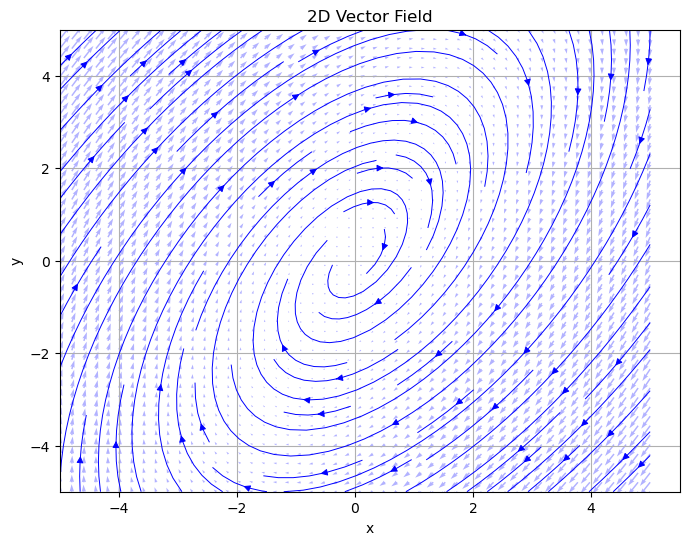

In [71]:
bounds = [[-5, 5], [-5, 5]]
plot_2D_vector_field(linearODE1, bounds, streamplot=True)

### Tests

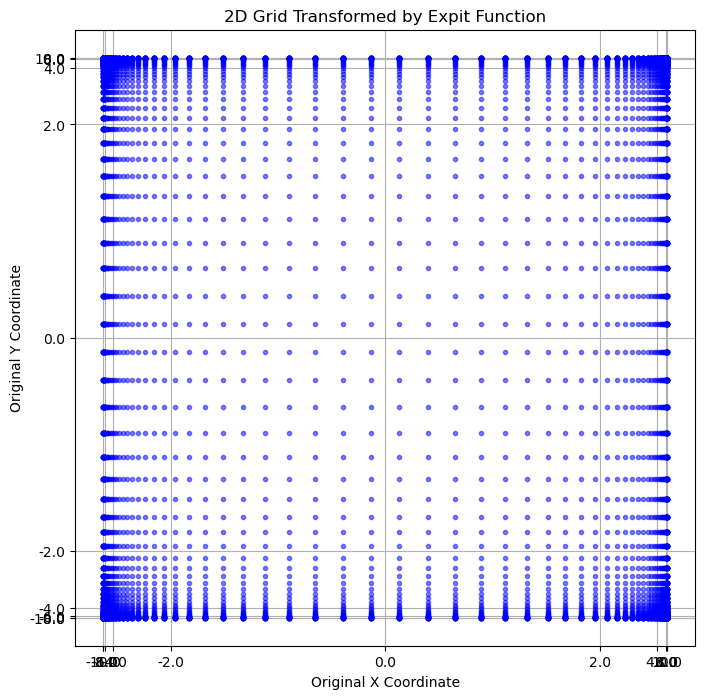

In [70]:
# Create a grid of points in the infinite space
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)

# Apply the expit transformation to both axes
X_transformed = expit(X)
Y_transformed = expit(Y)

# Plot the transformed grid
plt.figure(figsize=(8, 8))
plt.plot(X_transformed, Y_transformed, 'b.', alpha=0.5)  # Plot grid points

# Set the axes labels to show the original coordinates
original_x_ticks = np.linspace(-10, 10, 11)
original_y_ticks = np.linspace(-10, 10, 11)
transformed_x_ticks = expit(original_x_ticks)
transformed_y_ticks = expit(original_y_ticks)

plt.xticks(transformed_x_ticks, labels=[f'{tick:.1f}' for tick in original_x_ticks])
plt.yticks(transformed_y_ticks, labels=[f'{tick:.1f}' for tick in original_y_ticks])

plt.title('2D Grid Transformed by Expit Function')
plt.xlabel('Original X Coordinate')
plt.ylabel('Original Y Coordinate')
plt.grid(True)
plt.show()